# CISA KVE EPSS Data Analyis 

In [1]:
import pandas as pd
import json
import requests
import os
import glob
import numpy as np

In [2]:
cisa_df = pd.read_csv("https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv")
cisa_df = cisa_df
cisa_df.columns = cisa_df.columns.str.strip("\u200b")
cisa_df = cisa_df.rename(columns={"cveID": "CVE", "shortDescription" : "Description", "dateAdded" : "Date"})

In [3]:
epss = pd.read_csv('epss_scores-current.csv', skiprows=1)
epss = epss.rename(columns={"cve": "CVE", "epss" : "EPSS", "percentile" : "EPSS Percentile"})

In [4]:
row_accumulator = []
for filename in glob.glob('nvdcve-2.0-*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['vulnerabilities']:
            cve = entry['cve']['id']
            try:
                base_score = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['baseScore']
            except KeyError:
                base_score = '0.0'
            new_row = { 
                'CVE': cve, 
                'CVSS3': base_score,
            }
            row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)
        
nvd['CVSS3'] = pd.to_numeric(nvd['CVSS3']);
nvd['CVSS3'] = nvd['CVSS3'].replace(0, np.nan);       

In [5]:
epss_kev = pd.merge(cisa_df, epss, left_on='CVE', right_on='CVE')
epss_kev_nvd =  pd.merge(epss_kev, nvd, left_on='CVE', right_on='CVE')
epss_kev_nvd =  epss_kev_nvd[["CVE", "CVSS3", "EPSS", "EPSS Percentile", "Description", "Date"]]

## CISA KEV Score Scatter Plot

/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1351: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


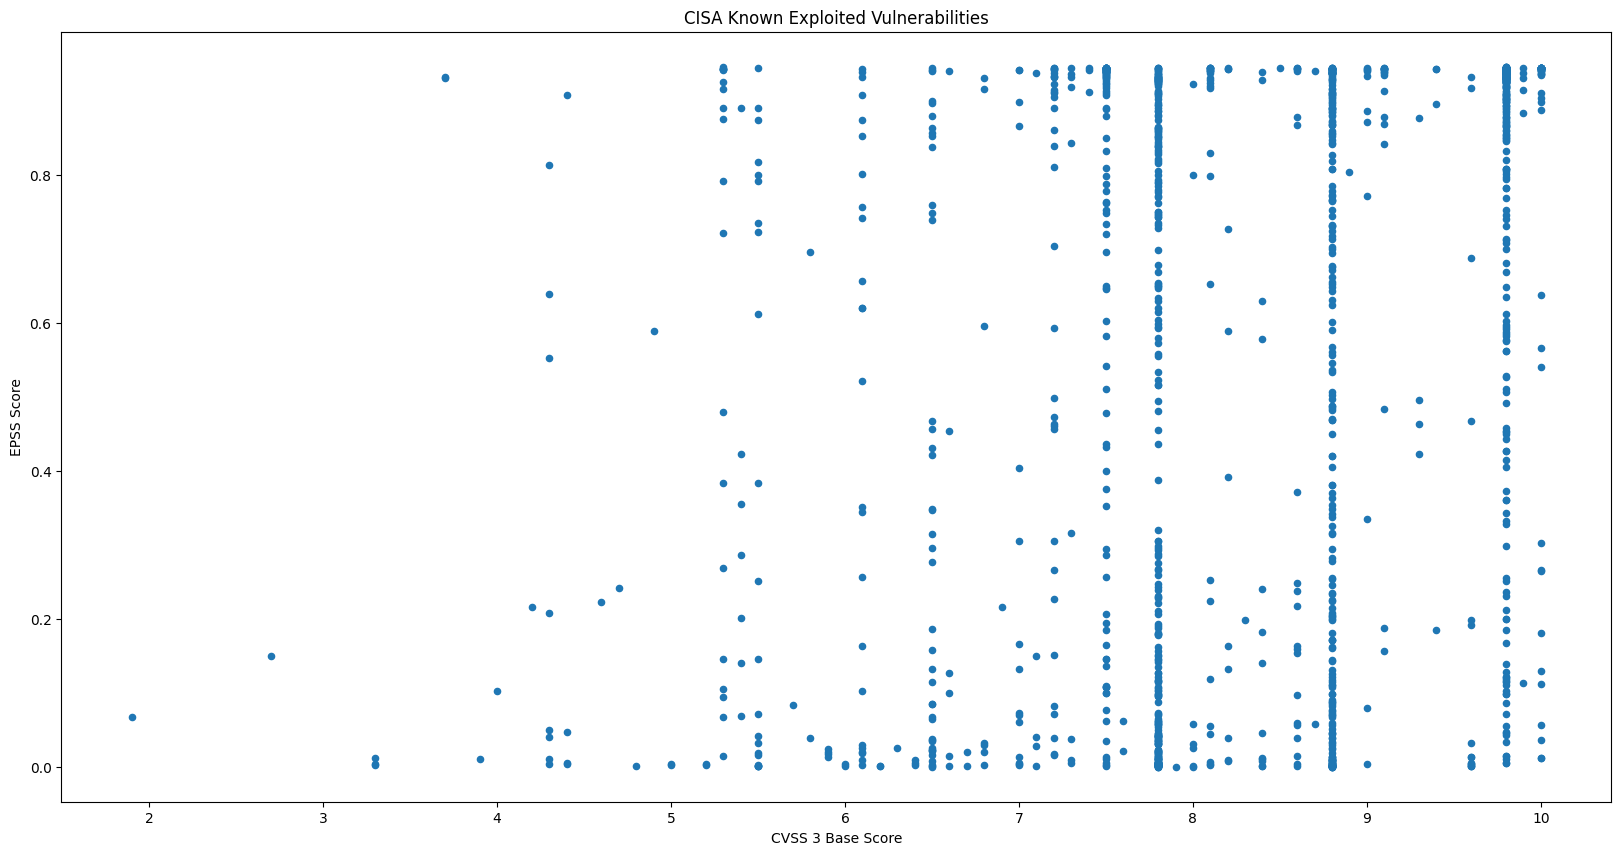

In [6]:
ax = epss_kev_nvd.plot.scatter(x='CVSS3',
                     y='EPSS',
                     colormap='jet',
                     figsize=(20, 10),
                     title='CISA Known Exploited Vulnerabilities');
ax.set_xlabel("CVSS 3 Base Score");
ax.set_ylabel("EPSS Score");
ax.figure.savefig('epss_kev_nvd.png');

## Export to CSV

In [7]:
epss_kev_nvd.to_csv("epss_kev_nvd.csv", index=False)
epss_kev_nvd.head(10)

,CVE,CVSS3,EPSS,EPSS Percentile,Description,Date
0,CVE-2025-48384,8.0,0.00020,0.03444,Git contains a link following vulnerability th...,2025-08-25
1,CVE-2024-8068,8.0,0.00092,0.26917,Citrix Session Recording contains an improper ...,2025-08-25
2,CVE-2024-8069,8.8,0.53593,0.97895,Citrix Session Recording contains a deserializ...,2025-08-25
3,CVE-2025-43300,8.8,0.00903,0.74738,"Apple iOS, iPadOS, and macOS contain an out-of...",2025-08-21
4,CVE-2025-54948,9.4,0.18488,0.94991,Trend Micro Apex One Management Console (on-pr...,2025-08-18
5,CVE-2025-8876,8.8,0.23465,0.95750,N-able N-Central contains a command injection ...,2025-08-13
6,CVE-2025-8875,7.8,0.11731,0.93429,N-able N-Central contains an insecure deserial...,2025-08-13
7,CVE-2025-8088,8.8,0.06765,0.90913,RARLAB WinRAR contains a path traversal vulner...,2025-08-12
8,CVE-2007-0671,8.8,0.66160,0.98457,Microsoft Office Excel contains a remote code ...,2025-08-12
9,CVE-2013-3893,8.8,0.87062,0.99404,Microsoft Internet Explorer contains a memory ...,2025-08-12
